# GRCh38 DNase 12 kb CAE Optimize

**Task:** search over the embedding size, dense_units, regularization, and dropout.

**Insights:**

- An embedding of 12 and 10 dimensions leads to the lowest loss
- An embedding of 8 dimensions leads to almost the same performance
- Adding dropout makes things worse and given that the train, dev, and test loss is about the same we don't need it
- Gentle regularization (0.00001) doesn't harm but doesn't add much either so we don't need it
- Two dense usings seem to be enough. Adding more doesn't improve the loss

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
testing = False
    
# The base directory is one level up
base = '..'
settings_filepath = '../settings-grch38-chip-12kb.json'
search_filepath = '../cnn-optimize.json'

with open(settings_filepath, "r") as f:
    settings = json.load(f)

with open(search_filepath, "r") as f:
    search = json.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create training jobs

In [13]:
from jobs import jobs

jobs(
    os.path.relpath(search_filepath, base),
    os.path.relpath(settings_filepath, base),
    dataset="cnn-search",
    name="cnn-optimize",
    cluster="cox",
    epochs=25,
    batch_size=256,
    base=base,
    clear=False,
    verbose=False
)


Skipped creating 10 definition files as they already exists
Created slurm file for training 10 neural networks


## Test training run of the most complex CAE

In [ ]:
from train import train_on_single_dataset

model_name = 'cf-128-256-512-1024--ck-3-7-11-15--du---do-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m---bn-0-0-0-0--bni-0'

with open('../models/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

train_on_single_dataset(
    settings,
    'cnn-search',
    definition,
    epochs=2,
    batch_size=256,
    peak_weight=2,
    signal_weighting='logn',
    signal_weighting_zero_point_percentage=0.02,
    base=base,
    clear=True,
)

Check if all jobs finished successfully

In [2]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    'cnn-optimize', 'training', 'cnn-search', base=base
)

print(okay, not_found, outdated)

True [] []


## Create evaluation jobs

In [5]:
from evaluate import create_jobs

create_jobs(
    'cnn-optimize',
    name='cnn-optimize',
    dataset='cnn-search',
    cluster='cox',
    base=base,
    clear=False,
    incl_dtw=False,
)

Created slurm file for evaluating 144 neural networks


In [7]:
okay, not_found, outdated = check_status(
    'cnn-optimize', 'evaluation', 'cnn-search', base=base
)

print(okay, not_found, outdated)

True [] []


The data will be downloaded to `../data`.

In a terminal run: `sbatch evaluate-cnn-optimize-2.slurm`

## Compare

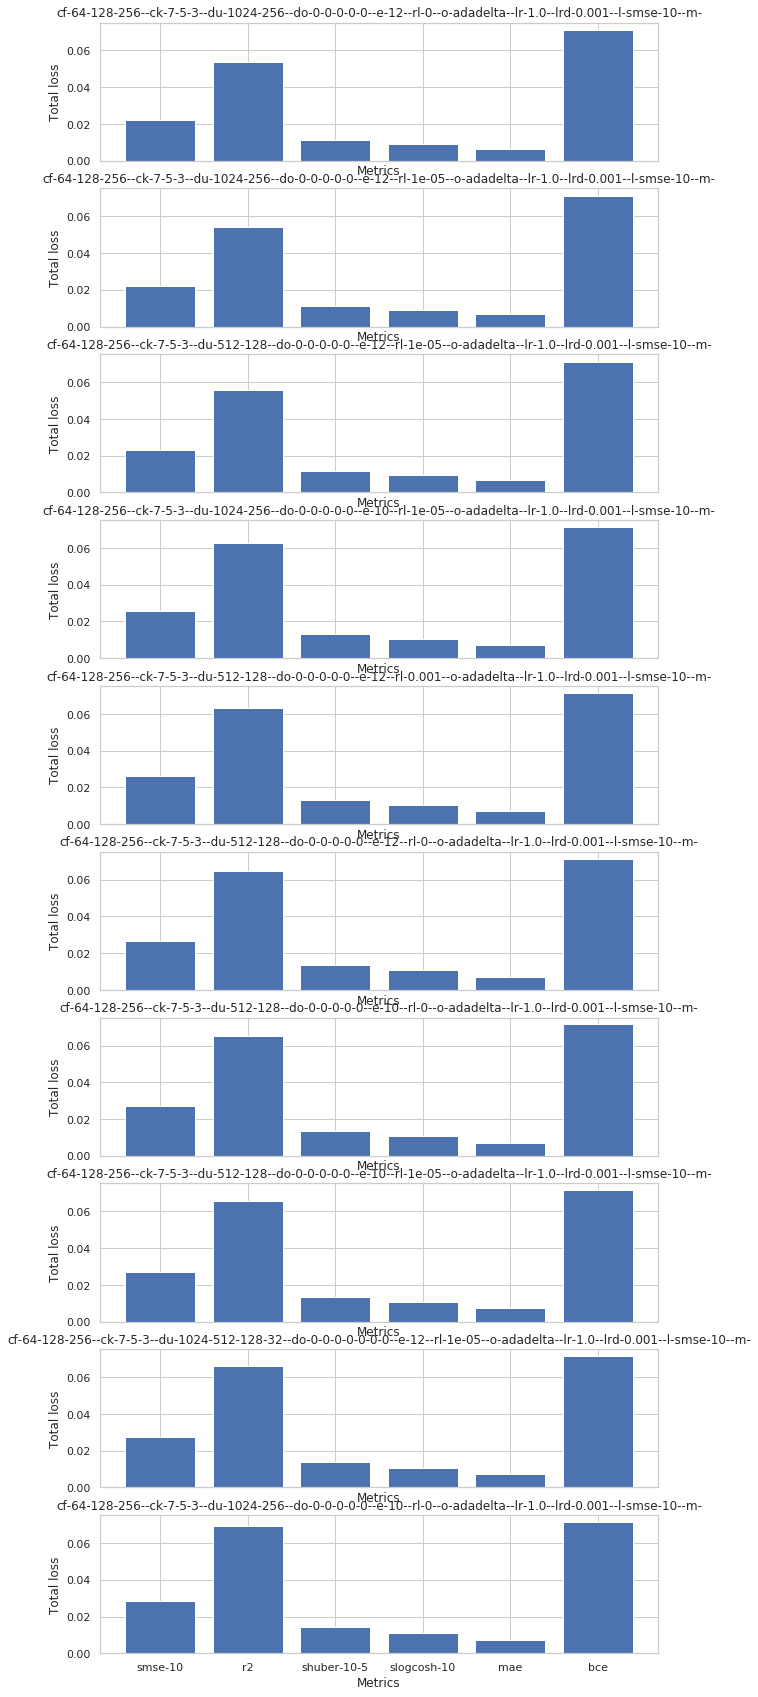

In [8]:
from compare import compare
    
performance = compare(
    'definitions-cnn-optimize.json',
    dataset_name='cnn-search',
    base=base,
    clear=False,
    verbose=False,
    silent=False,
    remove_common_prefix_from_df=True,
)

In [24]:
import qgrid

qgw = qgrid.show_grid(performance)
qgw

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

1024-256--do-0-0-0-0-0--e-12--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-
cf-64-128-256--ck-7-5-3--du-1024-256--do-0-0-0-0-0--e-12--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


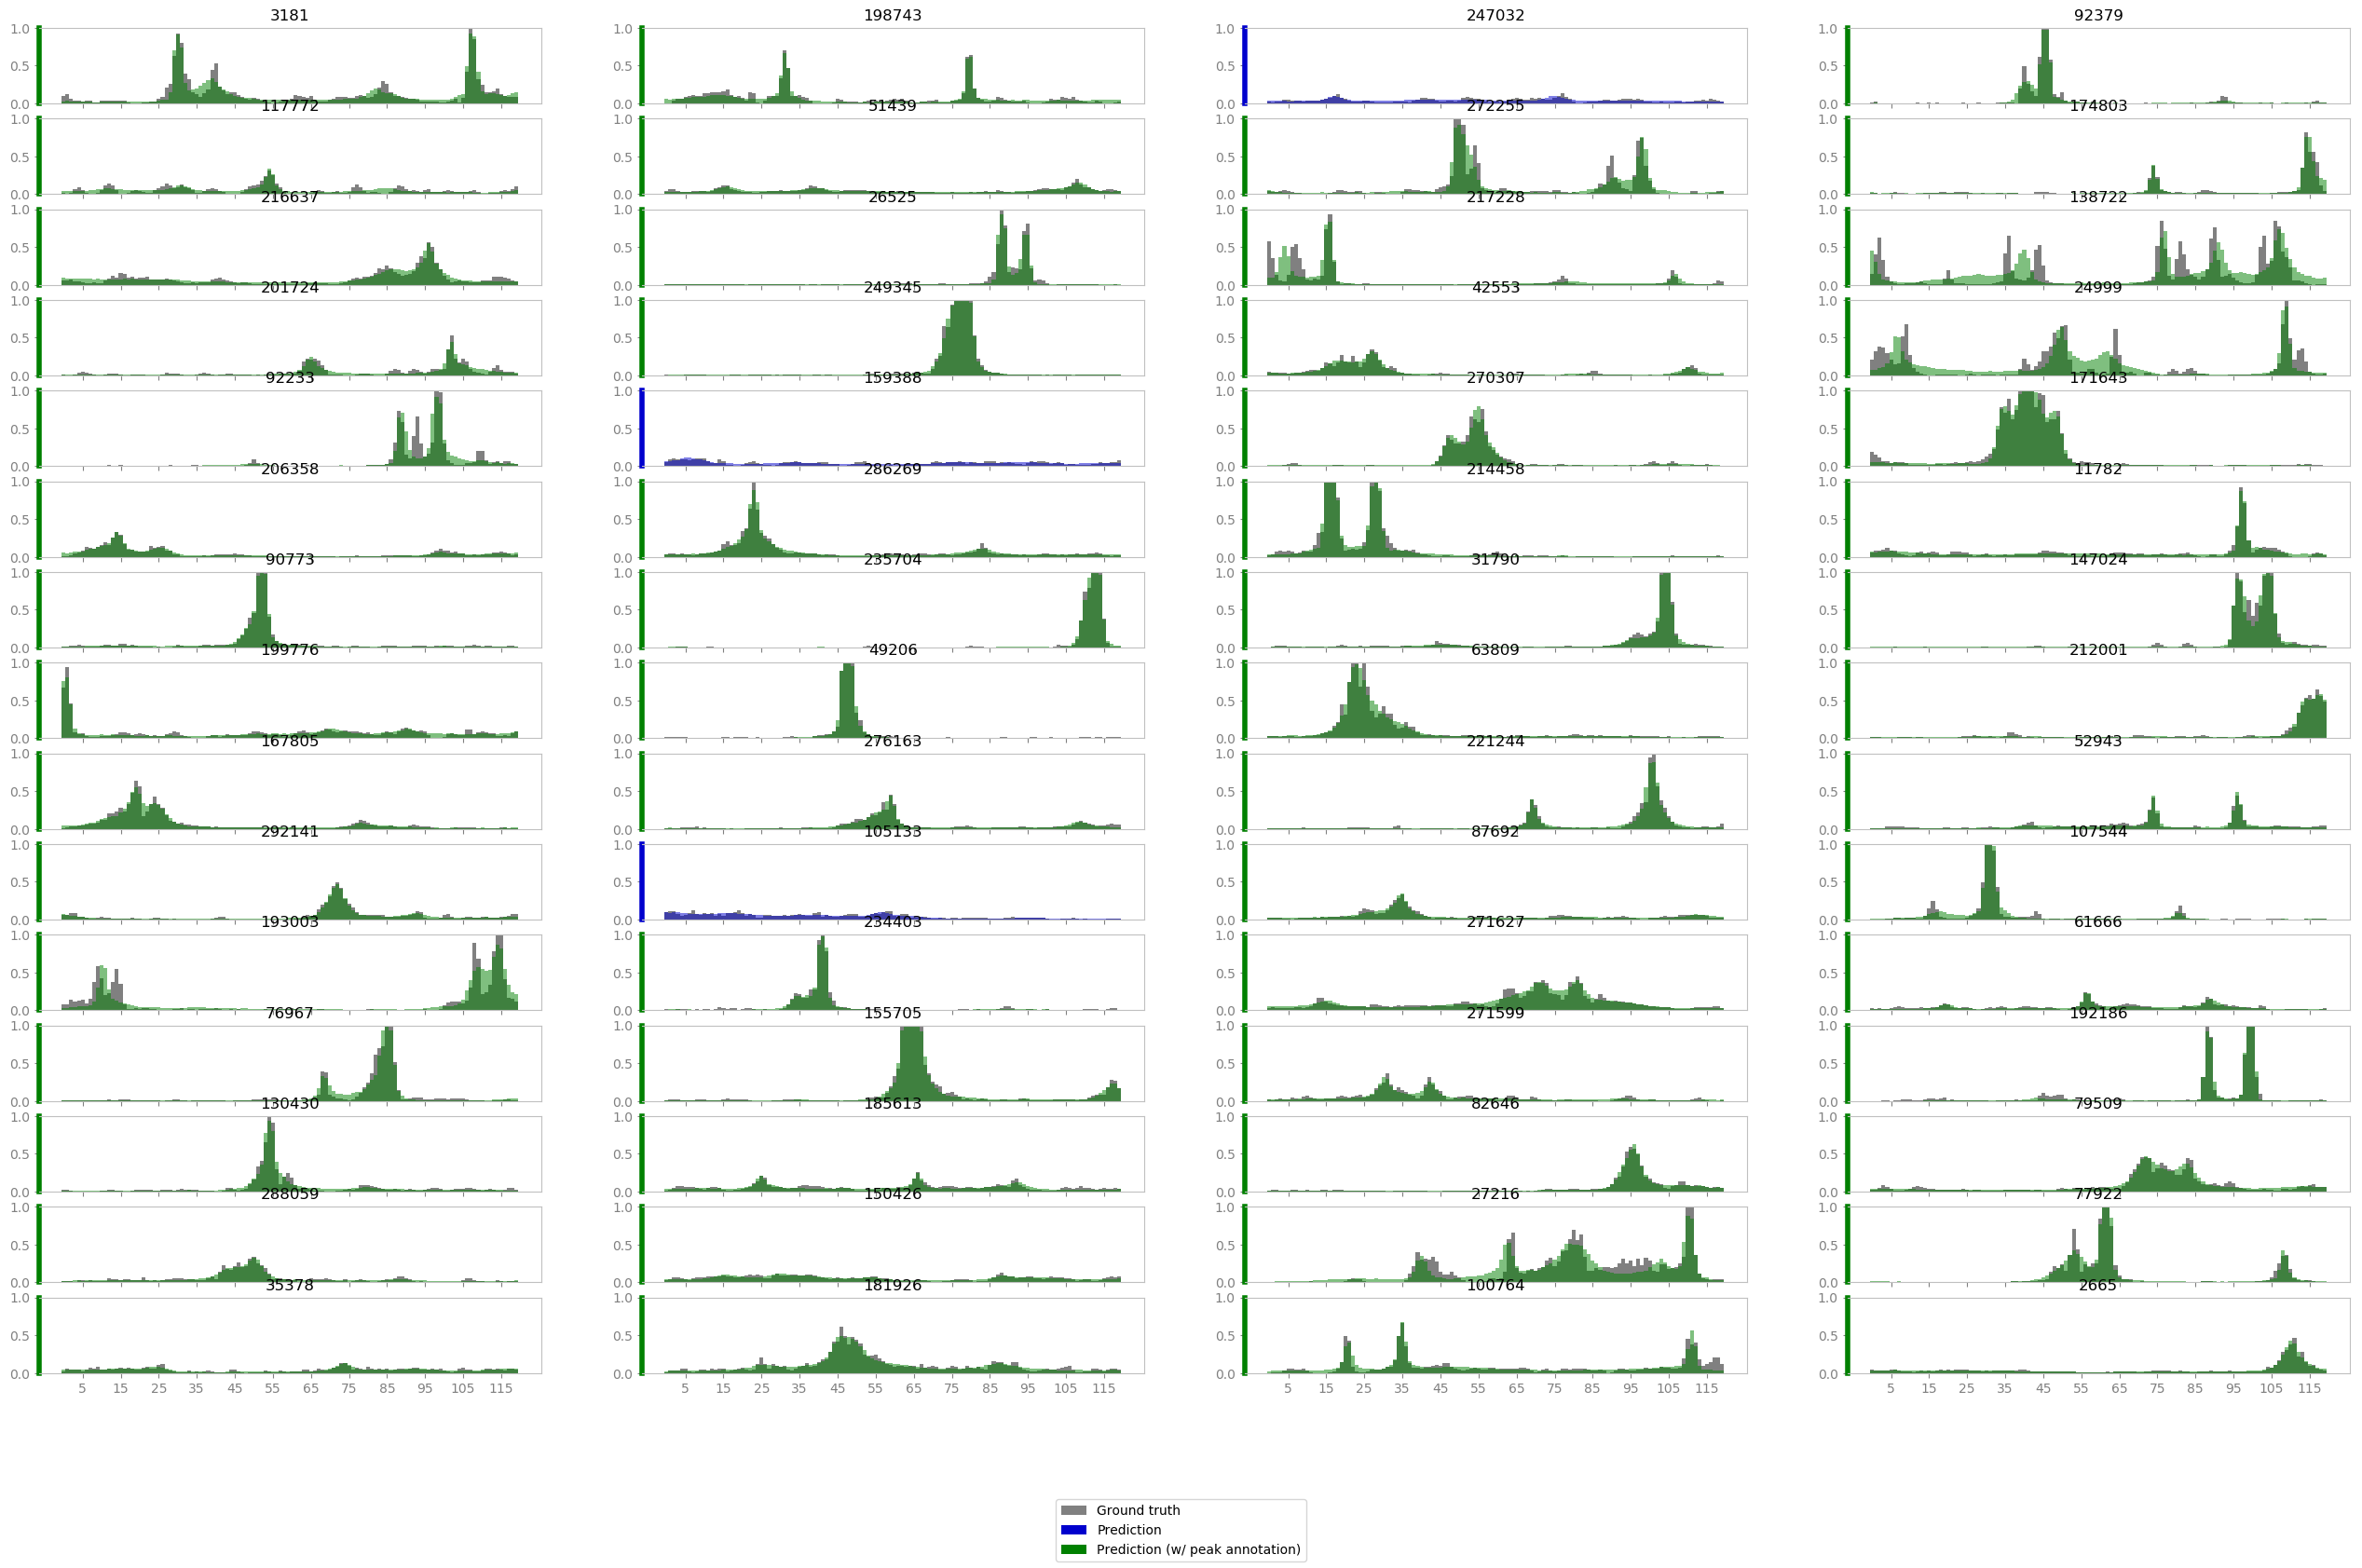

512-128--do-0-0-0-0-0--e-8--rl-1e-05--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-
cf-64-128-256--ck-7-5-3--du-512-128--do-0-0-0-0-0--e-8--rl-1e-05--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


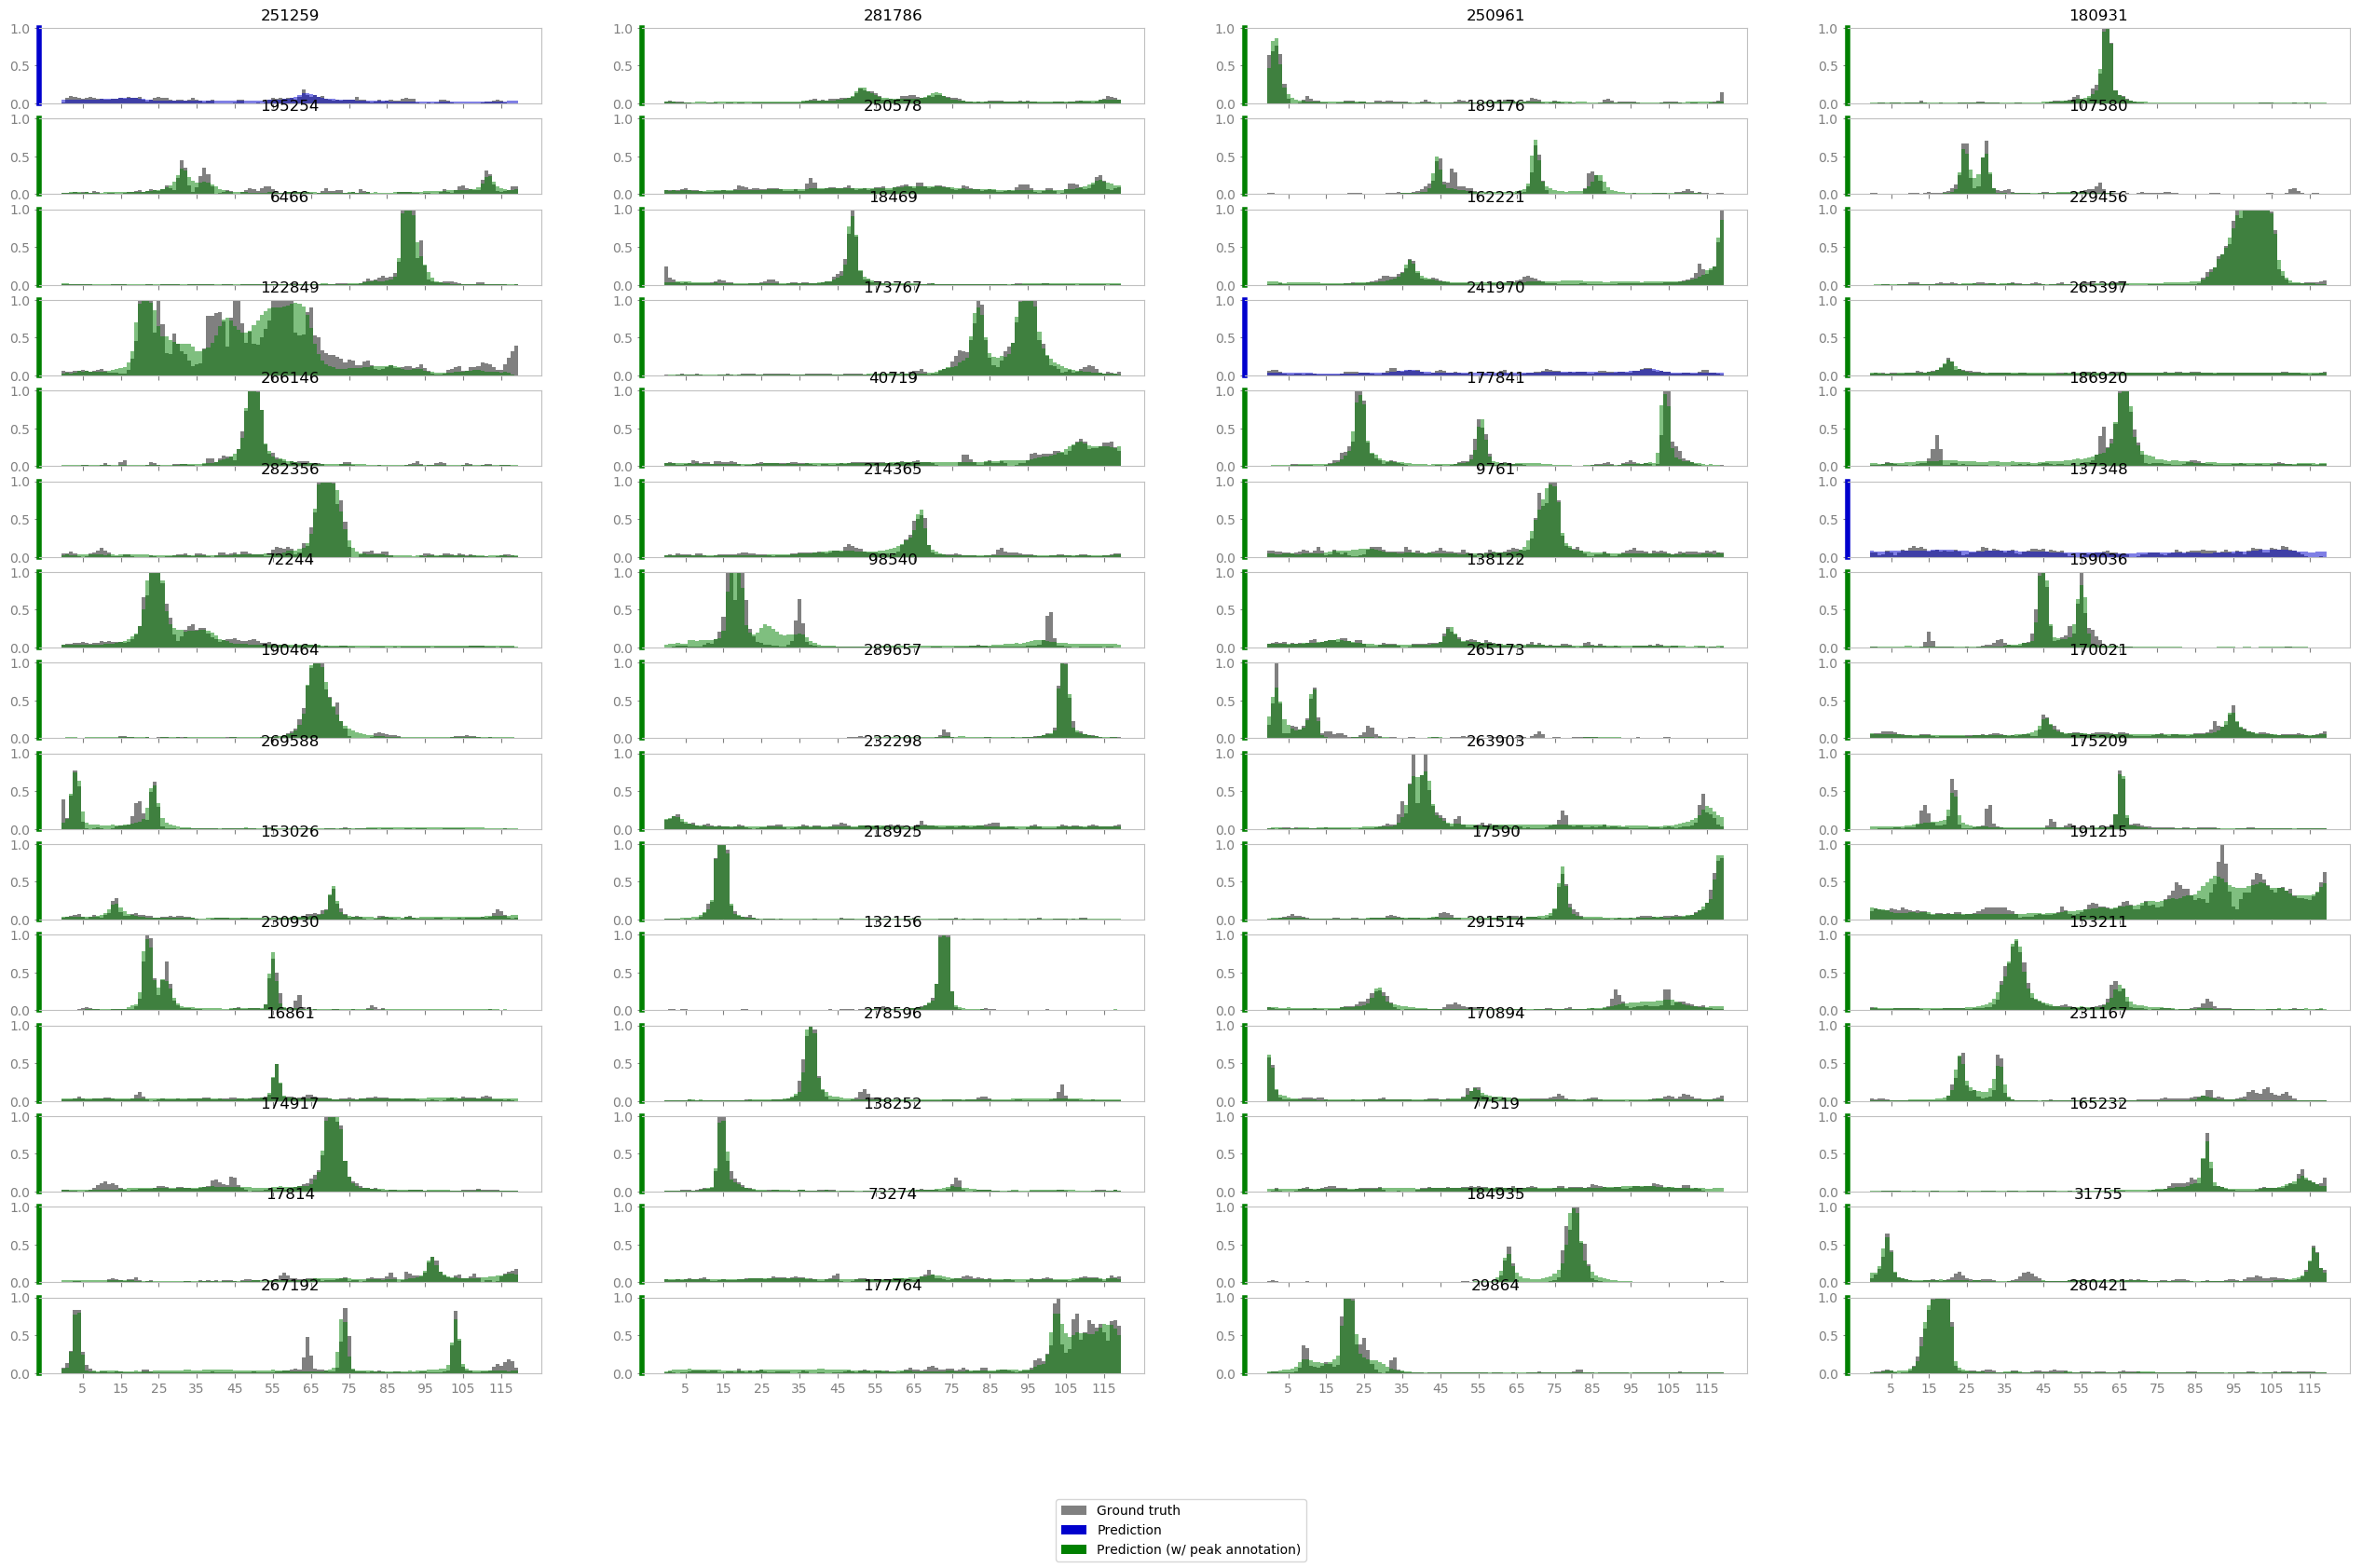

In [23]:
from IPython.core.display import Image, display

for model in qgw.get_selected_df().iterrows():
    print(model[0])
    full_model_name = 'cf-64-128-256--ck-7-5-3--du-{}'.format(model[0])
    print(full_model_name)
    display(Image(os.path.join(base, 'models', '{}---predictions-{}.png'.format(full_model_name, 'cnn-search'))))

1024-256--do-0-0-0-0-0--e-12--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


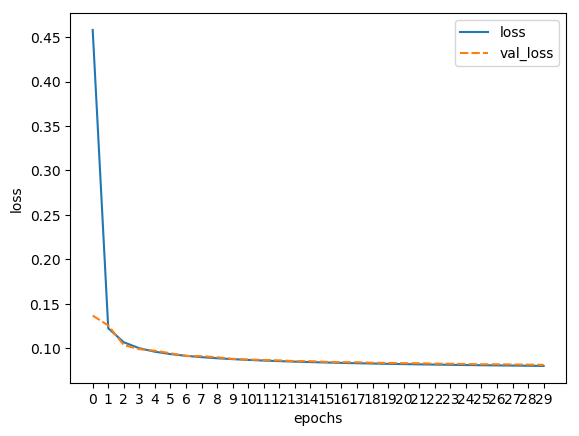

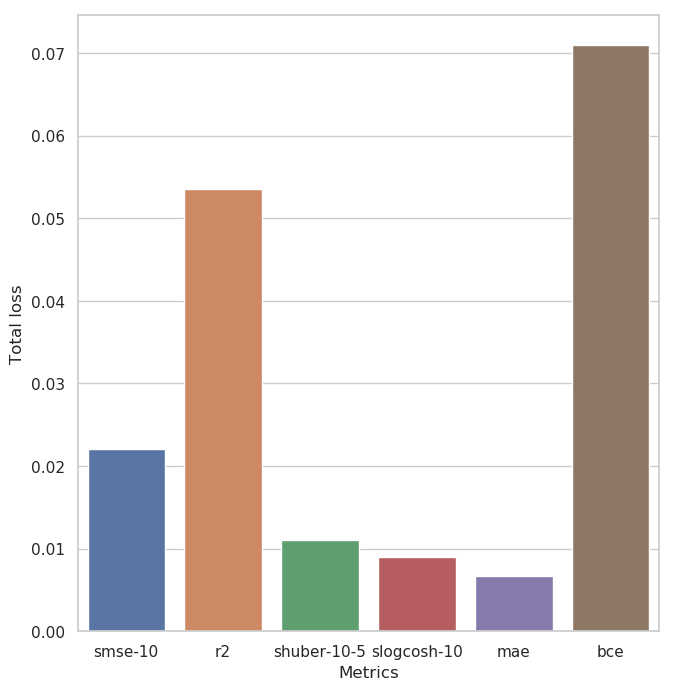

1024-256--do-0-0-0-0-0--e-12--rl-1e-05--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


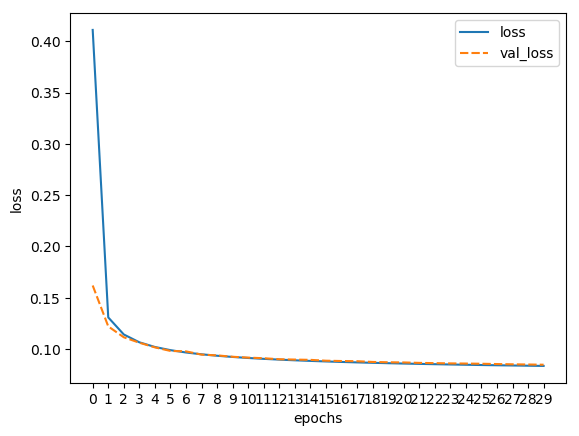

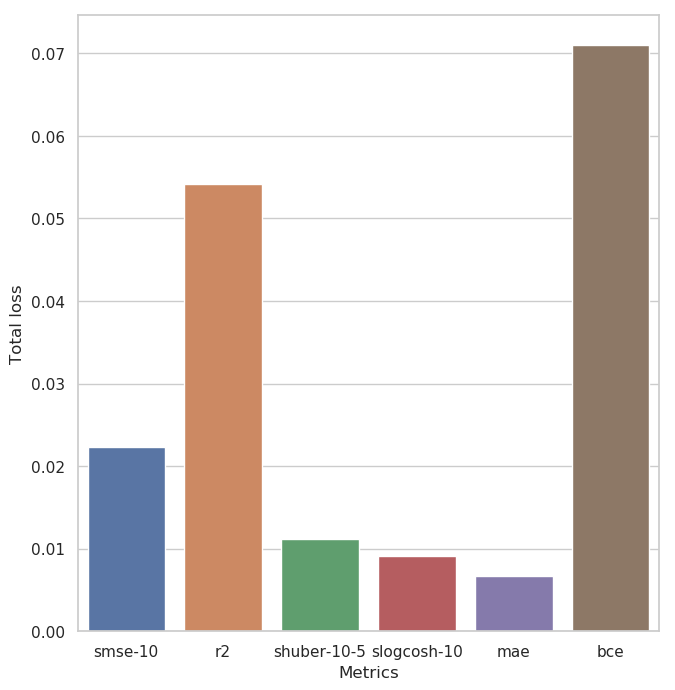

1024-256--do-0-0-0-0-0--e-10--rl-1e-05--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


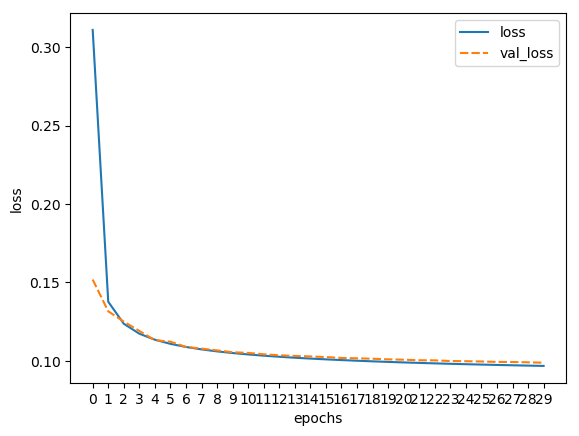

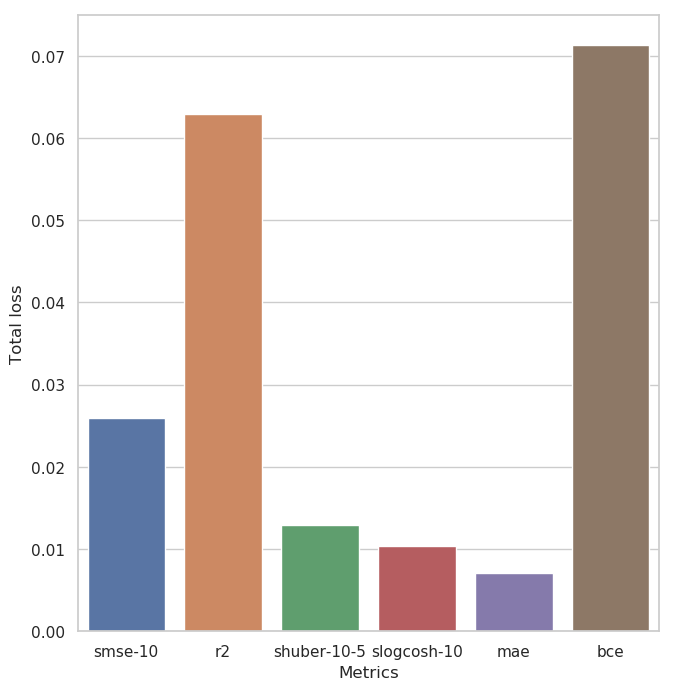

512-128--do-0-0-0-0-0--e-8--rl-1e-05--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


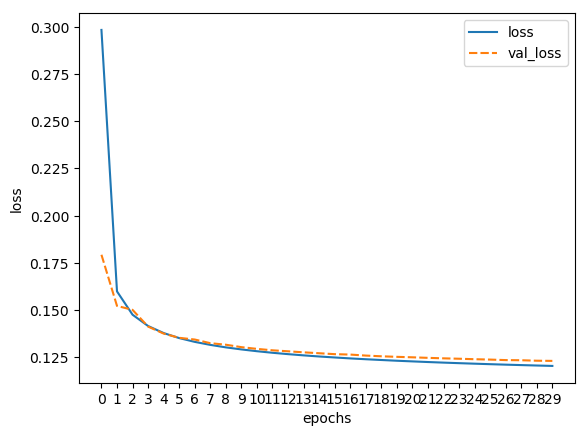

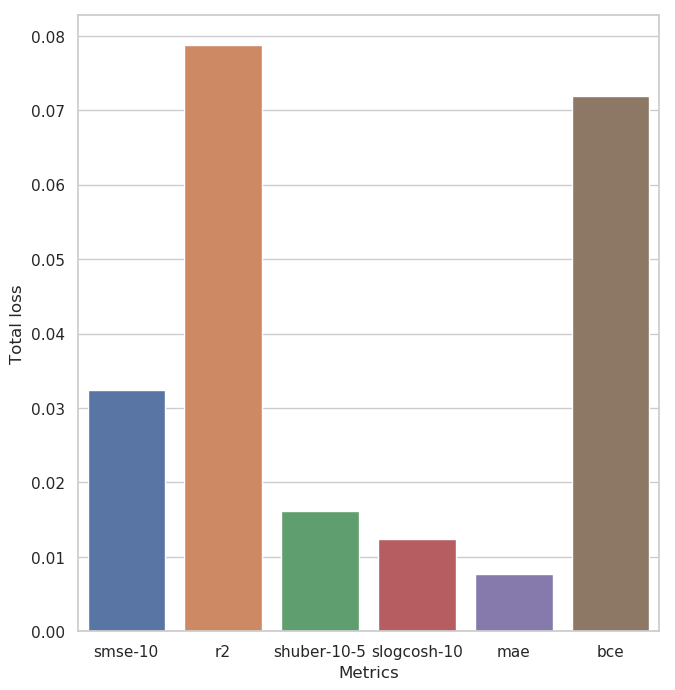

1024-256--do-0-0-0-0-0--e-6--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


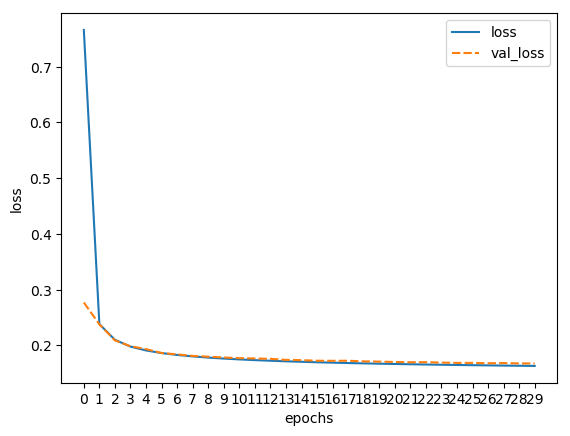

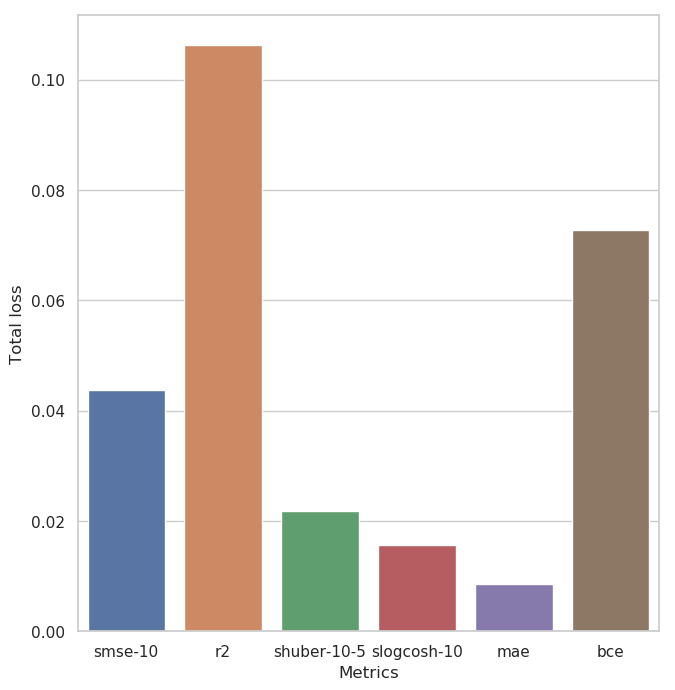

In [14]:
"""Look at the train, dev, and test error"""

from IPython.core.display import Image, display

for model in qgw.get_selected_df().iterrows():
    print(model[0])
    full_model_name = 'cf-64-128-256--ck-7-5-3--du-{}'.format(model[0])
    display(Image(os.path.join(base, 'models', '{}---train-loss-{}.png'.format(full_model_name, 'cnn-search'))))
    display(Image(os.path.join(base, 'models', '{}---test-loss-{}.png'.format(full_model_name, 'cnn-search'))))